# Illustration of ML development with a simple usecase & Algorithm

## Case Study

## Business Problem

A house managing company acquires houses from owners at a fixed price for a specified lease period. They then lease these houses to individuals at a higher rental rate, with the profit margin being the difference between the rental income and the agreed price. Recently, they have noticed a decline in their revenue. They suspect that the issue may be due to incorrect valuation when acquiring properties from landlords or owners

#### Use case validation (Validation using data)

There could be several potential reasons for the decrease in profit margins for a house managing company. 

These includes: Lower occupancy rate due to inefficient sales, Acquiring houses that are outdated or lack modern amenities, High overhead costs, Unfavorable market conditions, Tenant retention issues, Incorrect valuation, etc.

<span style="color:blue">We need to validate and confirm the assumption that incorrect valuation is one of the main reasons for the revenue decrease</span>

### Data
Assume there is data that includes details of houses and the rent paid last year in the area where this housing management company operates. This data is not limited to the houses they manage but includes information about all the houses in the area of interest

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Read data
housing_data1 = pd.read_excel('housing_data.xlsx', sheet_name = 'House_Details')
housing_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   HouseNo                       1002 non-null   int64  
 1   Landlord_Name                 1002 non-null   object 
 2   House_Area                    1001 non-null   float64
 3   No_of_Bedrooms                1002 non-null   int64  
 4   No_of_bathrooms               1002 non-null   int64  
 5   Balcony                       1002 non-null   int64  
 6   location                      991 non-null    object 
 7   Latitude                      1002 non-null   float64
 8   Longitude                     1002 non-null   float64
 9   zip_code                      1002 non-null   int64  
 10  Construction_Year             1002 non-null   int64  
 11  Distance_to_public_transport  1002 non-null   int64  
 12  Distance_to_super_market      1002 non-null   int64  
 13  Fur

In [2]:
#Top 5 records
housing_data1.head(5)

,HouseNo,Landlord_Name,House_Area,No_of_Bedrooms,No_of_bathrooms,Balcony,location,Latitude,Longitude,zip_code,Construction_Year,Distance_to_public_transport,Distance_to_super_market,Furnished_Status,Rental_Price
0,1001033,David J,1500.0,6,4,0,Urben,30.676757,-120.453307,99984,2020,5,9,Semi-Furnished,212995.591559
1,1001030,Guillermo Clayton,1579.0,5,5,0,Urben,30.676757,-120.453307,99987,2021,5,9,Unfurnished,257244.132642
2,1001030,Guillermo Clayton,1579.0,5,5,0,Urben,40.039491,-68.167801,99987,2021,5,9,Unfurnished,222012.163292
3,1001029,Everleigh Hebert,1365.0,5,4,1,Urben,40.039491,-68.167801,99987,2018,7,7,Furnished,233992.978641
4,1001028,Rayan Sanders,891.0,4,3,0,Rural,32.824121,-81.549408,99998,2002,4,3,Semi-Furnished,110134.250006


In [3]:
# housing_data1.describe()

##### EDA report using sweetviz package

In [4]:
import sweetviz as sv   
report = sv.analyze(housing_data1, target_feat='Rental_Price')
report.show_html("EDA.html")

                                             |                                                          | [  0…

Report EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##### Check for duplicates

In [5]:
print(f"Number of Duplicate records : {housing_data1.duplicated().sum()}")

Number of Duplicate records : 0


In [6]:
# duplicates = housing_data1[housing_data1.duplicated(keep=False)]
# duplicates

##### Replace the missing location details

In [7]:
print(f"Missing locations : {housing_data1.location.isna().sum()}")
zip_to_location = housing_data1.dropna(subset=['location']).set_index('zip_code')['location'].to_dict()
housing_data1['location'] = housing_data1.apply(lambda row: zip_to_location.get(row['zip_code'], row['location']), axis=1)
print(f"Missing locations after fix: {housing_data1.location.isna().sum()}")

Missing locations : 11
Missing locations after fix: 0


##### Create new features : near by schools

In [8]:
from geopy.distance import geodesic

# Load the school data
schools_df = pd.read_excel('housing_data.xlsx', sheet_name='School Details')
schools_df.head()

,School_Name,Latitude,Longitude
0,School 1,53.917975,-98.601900
1,School 2,54.541361,-97.179918
2,School 3,55.309993,-96.607152
3,School 4,55.692473,-96.929675
4,School 5,56.741147,-96.703788


In [9]:

# Function to calculate the distance between two points (latitude, longitude)
def calculate_distance(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Initialize lists to store the results
num_schools_nearby = []
min_distance = []
avg_distance_nearest_3 = []

# Iterate over each house
for index, house in housing_data1.iterrows():
    house_location = (house['Latitude'], house['Longitude'])
    
    # Calculate distances to all schools
    distances = []
    for _, school in schools_df.iterrows():
        school_location = (school['Latitude'], school['Longitude'])
        distance = calculate_distance(house_location, school_location)
        distances.append(distance)
    
    # Sort distances
    distances.sort()
    
    # Calculate the number of schools nearby (within 10 km radius)
    nearby_schools = [d for d in distances if d <= 10]
    num_schools_nearby.append(len(nearby_schools))
    
    # Calculate the minimum distance
    min_distance.append(min(distances))
    
    # Calculate the average distance of the nearest 3 schools
    avg_distance_nearest_3.append(sum(distances[:3]) / 3)

# Add the results to the houses dataframe
housing_data1['Num_Schools_Nearby'] = num_schools_nearby
housing_data1['Min_Distance'] = min_distance
housing_data1['Avg_Distance_Nearest_3'] = avg_distance_nearest_3

housing_data1.head(5)

,HouseNo,Landlord_Name,House_Area,No_of_Bedrooms,No_of_bathrooms,Balcony,location,Latitude,Longitude,zip_code,Construction_Year,Distance_to_public_transport,Distance_to_super_market,Furnished_Status,Rental_Price,Num_Schools_Nearby,Min_Distance,Avg_Distance_Nearest_3
0,1001033,David J,1500.0,6,4,0,Urben,30.676757,-120.453307,99984,2020,5,9,Semi-Furnished,212995.591559,0,363.166290,394.603604
1,1001030,Guillermo Clayton,1579.0,5,5,0,Urben,30.676757,-120.453307,99987,2021,5,9,Unfurnished,257244.132642,0,363.166290,394.603604
2,1001030,Guillermo Clayton,1579.0,5,5,0,Urben,40.039491,-68.167801,99987,2021,5,9,Unfurnished,222012.163292,0,181.993039,484.943296
3,1001029,Everleigh Hebert,1365.0,5,4,1,Urben,40.039491,-68.167801,99987,2018,7,7,Furnished,233992.978641,0,181.993039,484.943296
4,1001028,Rayan Sanders,891.0,4,3,0,Rural,32.824121,-81.549408,99998,2002,4,3,Semi-Furnished,110134.250006,0,394.110912,515.693717


In [10]:
report = sv.analyze(housing_data1, target_feat='Rental_Price')
report.show_html("EDA_with_schools.html")

                                             |                                                          | [  0…

Report EDA_with_schools.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


##### Convert text category columns to numeric features

###### Location

In [11]:
location_type_df = pd.get_dummies(housing_data1['location'], prefix='location_type')
print(location_type_df.head())

   location_type_Rural  location_type_Urben
0                False                 True
1                False                 True
2                False                 True
3                False                 True
4                 True                False


In [12]:
housing_data1 = pd.concat([housing_data1, location_type_df], axis=1)
print(housing_data1.dtypes)

HouseNo                           int64
Landlord_Name                    object
House_Area                      float64
No_of_Bedrooms                    int64
No_of_bathrooms                   int64
Balcony                           int64
location                         object
Latitude                        float64
Longitude                       float64
zip_code                          int64
Construction_Year                 int64
Distance_to_public_transport      int64
Distance_to_super_market          int64
Furnished_Status                 object
Rental_Price                    float64
Num_Schools_Nearby                int64
Min_Distance                    float64
Avg_Distance_Nearest_3          float64
location_type_Rural                bool
location_type_Urben                bool
dtype: object


###### Furnished_Status  - Ordinal column

In [13]:
Furnished_Status_mapping = {'Unfurnished': 1, 'Semi-Furnished': 2, 'Furnished': 3}
housing_data1['Furnished_Status_order'] = housing_data1['Furnished_Status'].map(Furnished_Status_mapping)
housing_data1[['HouseNo', 'Furnished_Status','Furnished_Status_order' ]].head()

,HouseNo,Furnished_Status,Furnished_Status_order
0,1001033,Semi-Furnished,2
1,1001030,Unfurnished,1
2,1001030,Unfurnished,1
3,1001029,Furnished,3
4,1001028,Semi-Furnished,2


#### Create Age of house feature from Construction_Year column

In [14]:
run_year =2025
housing_data1['House_Age_in_years'] =  run_year - housing_data1['Construction_Year']
housing_data1.head()

,HouseNo,Landlord_Name,House_Area,No_of_Bedrooms,No_of_bathrooms,Balcony,location,Latitude,Longitude,zip_code,Construction_Year,Distance_to_public_transport,Distance_to_super_market,Furnished_Status,Rental_Price,Num_Schools_Nearby,Min_Distance,Avg_Distance_Nearest_3,location_type_Rural,location_type_Urben,Furnished_Status_order,House_Age_in_years
0,1001033,David J,1500.0,6,4,0,Urben,30.676757,-120.453307,99984,2020,5,9,Semi-Furnished,212995.591559,0,363.166290,394.603604,False,True,2,5
1,1001030,Guillermo Clayton,1579.0,5,5,0,Urben,30.676757,-120.453307,99987,2021,5,9,Unfurnished,257244.132642,0,363.166290,394.603604,False,True,1,4
2,1001030,Guillermo Clayton,1579.0,5,5,0,Urben,40.039491,-68.167801,99987,2021,5,9,Unfurnished,222012.163292,0,181.993039,484.943296,False,True,1,4
3,1001029,Everleigh Hebert,1365.0,5,4,1,Urben,40.039491,-68.167801,99987,2018,7,7,Furnished,233992.978641,0,181.993039,484.943296,False,True,3,7
4,1001028,Rayan Sanders,891.0,4,3,0,Rural,32.824121,-81.549408,99998,2002,4,3,Semi-Furnished,110134.250006,0,394.110912,515.693717,True,False,2,23


In [15]:
report = sv.analyze(housing_data1, target_feat='Rental_Price')
report.show_html("final_eda_summary.html")

                                             |                                                          | [  0…

Report final_eda_summary.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


 # 

##### House_Area and No_of_Bedrooms are highly correlated. Including both these featutes together will not add any value to predict Rental_Price. 
##### Dropping No_of_Bedrooms and create new column called Extra_Bathroom

In [16]:
housing_data1['Extra_Bathroom'] = housing_data1['No_of_Bedrooms'] - housing_data1['No_of_bathrooms']
housing_data1.drop(columns= ['No_of_Bedrooms', 'No_of_bathrooms'], inplace=True)

In [17]:
housing_data1.columns

Index(['HouseNo', 'Landlord_Name', 'House_Area', 'Balcony', 'location',
       'Latitude', 'Longitude', 'zip_code', 'Construction_Year',
       'Distance_to_public_transport', 'Distance_to_super_market',
       'Furnished_Status', 'Rental_Price', 'Num_Schools_Nearby',
       'Min_Distance', 'Avg_Distance_Nearest_3', 'location_type_Rural',
       'location_type_Urben', 'Furnished_Status_order', 'House_Age_in_years',
       'Extra_Bathroom'],
      dtype='object')

##### Also, dropping location_type_Urban since Rural and Urban are complementary to each other, meaning if Rural = 1, then Urban = 0

In [18]:
housing_data1.drop(columns= ['location_type_Urben'], inplace=True)

In [19]:
housing_data1.columns

Index(['HouseNo', 'Landlord_Name', 'House_Area', 'Balcony', 'location',
       'Latitude', 'Longitude', 'zip_code', 'Construction_Year',
       'Distance_to_public_transport', 'Distance_to_super_market',
       'Furnished_Status', 'Rental_Price', 'Num_Schools_Nearby',
       'Min_Distance', 'Avg_Distance_Nearest_3', 'location_type_Rural',
       'Furnished_Status_order', 'House_Age_in_years', 'Extra_Bathroom'],
      dtype='object')

In [20]:
housing_data2 = housing_data1[['House_Area',  'Extra_Bathroom', 'Balcony',   
        'Distance_to_public_transport', 'Distance_to_super_market',  
       'Num_Schools_Nearby', 'Min_Distance', 'Avg_Distance_Nearest_3',
       'location_type_Rural', 'Furnished_Status_order', 'House_Age_in_years', 'Rental_Price']]
print(housing_data2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   House_Area                    1001 non-null   float64
 1   Extra_Bathroom                1002 non-null   int64  
 2   Balcony                       1002 non-null   int64  
 3   Distance_to_public_transport  1002 non-null   int64  
 4   Distance_to_super_market      1002 non-null   int64  
 5   Num_Schools_Nearby            1002 non-null   int64  
 6   Min_Distance                  1002 non-null   float64
 7   Avg_Distance_Nearest_3        1002 non-null   float64
 8   location_type_Rural           1002 non-null   bool   
 9   Furnished_Status_order        1002 non-null   int64  
 10  House_Age_in_years            1002 non-null   int64  
 11  Rental_Price                  1002 non-null   float64
dtypes: bool(1), float64(4), int64(7)
memory usage: 87.2 KB
None


In [21]:
housing_data2 = housing_data2.dropna()
housing_data2.shape

(1001, 12)

<span style="color:red">Data Quality: Place holder</span>

In [22]:
report = sv.analyze(housing_data2, target_feat='Rental_Price')
report.show_html("final_eda_summary.html")

                                             |                                                          | [  0…

Report final_eda_summary.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


#
#

### Model Traning

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
# Features
X = housing_data2[['House_Area',  'Extra_Bathroom', 'Balcony',   
        'Distance_to_public_transport', 'Distance_to_super_market',  
       'Num_Schools_Nearby', 'Min_Distance', 'Avg_Distance_Nearest_3',
       'location_type_Rural', 'Furnished_Status_order', 'House_Age_in_years']]

# Target variable
y = housing_data2['Rental_Price']   


##### Split data for traning and validation

In [25]:
# 80% data fro traning, 20% for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Training data structure - X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"validation data structure - X_test: {X_test.shape}, y_test: {y_test.shape}")

Training data structure - X_train: (800, 11), y_train: (800,)
validation data structure - X_test: (201, 11), y_test: (201,)


##### Check the distribution of traning & validation data

In [26]:
X_train.describe()

,House_Area,Extra_Bathroom,Balcony,Distance_to_public_transport,Distance_to_super_market,Num_Schools_Nearby,Min_Distance,Avg_Distance_Nearest_3,Furnished_Status_order,House_Age_in_years
count,800.00000,800.000000,800.000000,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,771.21250,-0.092500,0.482500,5.50625,5.522500,0.021250,426.222902,635.702639,2.001250,12.787500
std,345.89178,1.274156,0.500006,2.91858,2.903021,0.144307,261.676619,245.334058,0.818282,7.247102
min,217.00000,-4.000000,0.000000,1.00000,1.000000,0.000000,1.490397,245.083941,1.000000,0.000000
25%,478.50000,-1.000000,0.000000,3.00000,3.000000,0.000000,236.282465,432.502391,1.000000,7.000000
50%,744.50000,0.000000,0.000000,5.00000,6.000000,0.000000,366.444153,572.744282,2.000000,13.000000
75%,1006.00000,1.000000,1.000000,8.00000,8.000000,0.000000,586.752007,798.065583,3.000000,19.000000
max,1778.00000,2.000000,1.000000,10.00000,10.000000,1.000000,1164.751781,1416.101462,3.000000,25.000000


In [27]:
X_test.describe()

,House_Area,Extra_Bathroom,Balcony,Distance_to_public_transport,Distance_to_super_market,Num_Schools_Nearby,Min_Distance,Avg_Distance_Nearest_3,Furnished_Status_order,House_Age_in_years
count,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000,201.000000
mean,748.373134,-0.089552,0.532338,5.457711,5.587065,0.014925,455.276504,664.082521,1.990050,11.771144
std,333.019436,1.312227,0.500199,2.859974,2.837892,0.121557,271.671061,259.322754,0.824561,7.174076
min,221.000000,-4.000000,0.000000,1.000000,1.000000,0.000000,1.515667,216.012263,1.000000,0.000000
25%,477.000000,-1.000000,0.000000,3.000000,3.000000,0.000000,254.550153,448.700276,1.000000,5.000000
50%,706.000000,0.000000,1.000000,5.000000,6.000000,0.000000,399.819337,647.104275,2.000000,11.000000
75%,980.000000,1.000000,1.000000,8.000000,8.000000,0.000000,585.948175,830.159074,3.000000,17.000000
max,1677.000000,2.000000,1.000000,10.000000,10.000000,1.000000,1186.918673,1461.004662,3.000000,25.000000


#### Model Training - Linear regression model

In [28]:
y_train


251     58793.444194
941     23122.528883
48     237624.549331
970    205697.011014
802     93991.809728
           ...      
768     33529.613278
73     127648.394398
909    115260.183188
236     26872.109009
38     231883.560528
Name: Rental_Price, Length: 800, dtype: float64

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [30]:


# printing Regression formula 
intercept = model.intercept_
coefficients = model.coef_
formula = f"Rental_Price = {intercept:.2f}"
for feature, coef in zip(X_train.columns, coefficients):
    formula += f" + ({coef:.2f} * {feature})"

print("Regression Formula:")
print(formula)

Regression Formula:
Rental_Price = -66716.46 + (166.13 * House_Area) + (-605.55 * Extra_Bathroom) + (-2183.39 * Balcony) + (463.85 * Distance_to_public_transport) + (3676.44 * Distance_to_super_market) + (221373.18 * Num_Schools_Nearby) + (-31.65 * Min_Distance) + (-0.14 * Avg_Distance_Nearest_3) + (-2090.06 * location_type_Rural) + (17734.48 * Furnished_Status_order) + (117.87 * House_Age_in_years)


In [31]:
y_train_pred = model.predict(X_train)

In [32]:
len(y_train_pred)

800

In [33]:
r2_train = r2_score(y_train_pred, y_train)
print(f"Traning Data : R^2 Score: {r2_train}")

Traning Data : R^2 Score: 0.8047343874280597


#### Model Validation

In [34]:
y_test

952    139572.442007
636     34320.425955
800     82055.263227
788     36316.936515
496     89848.957447
           ...      
590     95403.807988
552     46138.282343
820     14163.632955
208    106096.977762
346     48452.551282
Name: Rental_Price, Length: 201, dtype: float64

In [35]:
y_pred = model.predict(X_test)

In [36]:
r2 = r2_score(y_test, y_pred)
print(f"Validation Data : R^2 Score: {r2}")

Validation Data : R^2 Score: 0.8212116516300056


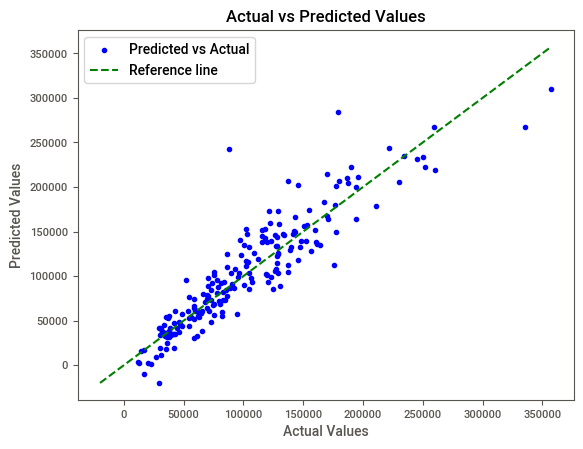

In [37]:
import matplotlib.pyplot as plt

# Create a scatter plot of actual vs predicted values for the test data
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Add a 45-degree diagonal reference line
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Reference line')

plt.legend()
plt.show()

#### Saving model object as file for future inference (predictions)

In [38]:
import pickle
with open('./model_linear_reg.pkl', 'wb') as file:
    pickle.dump(model, file)

#### Loading model

In [39]:
with open('./model_linear_reg.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

#### Inference - using the loaded model object

In [40]:
sample_prediction_data = X_test.head(2)
sample_prediction_data

,House_Area,Extra_Bathroom,Balcony,Distance_to_public_transport,Distance_to_super_market,Num_Schools_Nearby,Min_Distance,Avg_Distance_Nearest_3,location_type_Rural,Furnished_Status_order,House_Age_in_years
952,1098.0,0,1,3,3,0,895.383297,1036.247552,True,2,12
636,380.0,-1,0,4,2,0,841.086224,994.187892,True,3,20


In [41]:
prediction = loaded_model.predict(sample_prediction_data)
prediction

array([132248.06861355,  32945.20556831])

# 

# 

## Using more complex Non-Linear Model

### Random forest regression model

In [42]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)

model.fit(X, y)
y_pred = model.predict(X)

# Calculate and print the R-squared value
r2 = r2_score(y, y_pred)
print(f"Random Forest Model - Training Data: R-squared: {r2}")

Random Forest Model - Training Data: R-squared: 0.98430009624809


In [43]:
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"Random Forest Model - Validation Data : R^2 Score: {r2}")

Random Forest Model - Validation Data : R^2 Score: 0.985874216314284


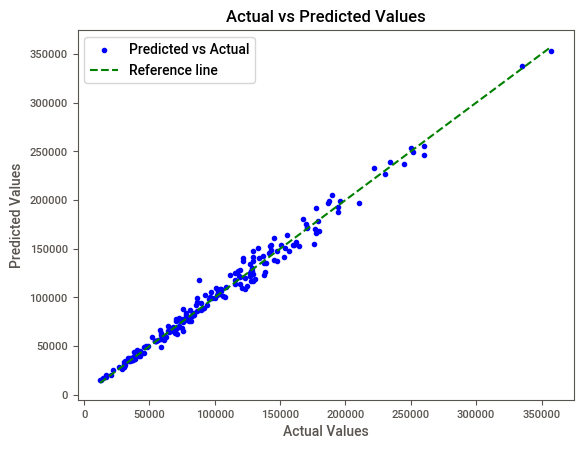

In [44]:
plt.scatter(y_test, y_pred, color='blue', label='Predicted vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')

# Add a 45-degree diagonal reference line
max_val = max(max(y_test), max(y_pred))
min_val = min(min(y_test), min(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='green', linestyle='--', label='Reference line')

plt.legend()
plt.show()

In [45]:
importance = model.feature_importances_
feature_names = X_test.columns
total_importance = sum(importance)
importance_percentage = {feature_names[i]: (importance[i] / total_importance) * 100 for i in range(len(importance))}

# Convert importance_percentage to DataFrame
importance_df = pd.DataFrame(list(importance_percentage.items()), columns=['Feature', 'Importance (%)'])

# Sort the DataFrame by descending importance
importance_df = importance_df.sort_values(by='Importance (%)', ascending=False)

# Print the sorted DataFrame
print(importance_df)

                         Feature  Importance (%)
0                     House_Area       61.146901
6                   Min_Distance       15.269804
5             Num_Schools_Nearby        8.115024
9         Furnished_Status_order        6.111161
4       Distance_to_super_market        2.846422
1                 Extra_Bathroom        1.819948
10            House_Age_in_years        1.698931
7         Avg_Distance_Nearest_3        1.619715
3   Distance_to_public_transport        0.763365
2                        Balcony        0.370346
8            location_type_Rural        0.238383


### XGB

In [46]:
import xgboost as xgb
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=50, random_state=42)

model.fit(X, y)
y_pred = model.predict(X)

r2 = r2_score(y, y_pred)
print(f"XGB Model - Training Data : R-squared: {r2}")

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"XGB Model - Validation Data : R^2 Score: {r2}")


importance = model.get_booster().get_score(importance_type='weight')

feature_names = X_test.columns
total_weight = sum(importance.values())
importance_percentage = {k: (v / total_weight) * 100 for k, v in importance.items()}
importance_df = pd.DataFrame(list(importance_percentage.items()), columns=['Feature', 'Importance (%)'])
importance_df = importance_df.sort_values(by='Importance (%)', ascending=False)
print("\n \n Feature Importance \n", importance_df)


XGB Model - Training Data : R-squared: 0.9977284212874504
XGB Model - Validation Data : R^2 Score: 0.9965972198620477

 
 Feature Importance 
                          Feature  Importance (%)
0                     House_Area       25.996893
6                   Min_Distance       21.025375
7         Avg_Distance_Nearest_3       12.118074
4       Distance_to_super_market        8.596582
10            House_Age_in_years        8.285862
1                 Extra_Bathroom        7.664423
3   Distance_to_public_transport        6.939410
9         Furnished_Status_order        5.282237
5             Num_Schools_Nearby        1.398239
2                        Balcony        1.346453
8            location_type_Rural        1.346453
